# Case Study 3
---
<div style="margin: -10px 0 20px 0"><small>Author: Daniel Kończyk (18208152)</small></div>

This case study focuses on implementing a rating prediction algorithm that can be used to produce recommendations for a given user. The study also tries to determine, if incorporating trust values in the algorithm can improve the quality of predictions. The evaluation is done on the `Epinions Dataset` provided on CS Moodle.

The study uses the following software:
* Python v3.7
* matplotlib package v3.1
* numpy package v1.16
* scikit-learn (sklearn) package v0.21
* scipy package 1.3

The notebook has been executed in the following environment:
* Linux and macOS (PC and laptop)
* 16GB RAM
* 4-core CPU

Due to the usage of sparse matrices wherever possible, the actual requirements in terms of memory are much lower than the available RAM and running the notebook along with the OS should not exceed 8GB.

We start the notebook with importing all required packages and modules:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn.preprocessing as pp
import datetime
import time
from operator import itemgetter
from scipy.sparse import csr_matrix, csc_matrix, vstack
from sklearn.model_selection import KFold

Next, we load the required data from text files, that were extracted from the `Epinions Dataset`. Rating data is loaded from `rating.txt` and trust data from `trust.txt`. Since the data indices start with `1`, we subtract `1` from every index to easily use 0-index data structures everywhere. This change however must be reflected in the user-facing interface, which will get the input based on the original data.

Since the rating data contains duplicates and is used for evaluation, additional pre-processing is being done, where we re-create the transaction data from the sparse matrix that was fed original data. This way we get only the distinct transaction values. Next, the transaction data is shuffled with a known seed, to have a consistent results over numerous runs, but it was tested and is expected, that setting any seed would not cause any significant change to the outcomes of the study.

In [2]:
R = np.loadtxt("rating.txt", dtype="int", usecols=(0,1,3))
t = np.loadtxt("trust.txt", dtype="int", usecols=(0,1))
#R = np.loadtxt("simple.txt", dtype="int", usecols=(0,1,2))
#t = np.loadtxt("simple_trust.txt", dtype="int", usecols=(0,1))
num_users = max(R[:,0])
num_items = max(R[:,1])
trust_data = np.ones((len(t),), dtype=int)
X = csr_matrix((R[:,2],(R[:,0]-1,R[:,1]-1)), shape=(num_users,num_items))
T = csr_matrix((trust_data,(t[:,0]-1,t[:,1]-1)), shape=(num_users,num_users))

# rebuild R to include only unique entries and be zero based
coo = X.tocoo()
R = np.column_stack((coo.row, coo.col, coo.data))
np.random.seed(999)
np.random.shuffle(R)

## Data exploration

We first look at the data that will be used for the evaluation of the algorithm, to better understand the possible outcomes. We start with general information about the dataset:

In [3]:
num_ratings = X.getnnz()
sparsity = 100-num_ratings/(num_users*num_items)*100
num_trust = T.getnnz()

stats = {
    "Data sparsity:": str(round(sparsity,5))+"%",
    "Number of users:": num_users,
    "Number of items:": num_items,
    "Number of ratings:": num_ratings,
    "Number of trust links:": num_trust
}

for k, v in stats.items():
    print(f'{k:<25} {v}')

Data sparsity:            99.98611%
Number of users:          22166
Number of items:          296277
Number of ratings:        912441
Number of trust links:    300091


As can be seen, the data is extremely sparse and the number of users is much smaller than the number of items in the system. There is also a significant number of trust links between users.

Now we take a closer look at each area, starting with users-ratings. While there are users with a lot of ratings, we restrict the plot to max 100 ratings per user, as the largest portion of the rating data is below that value:

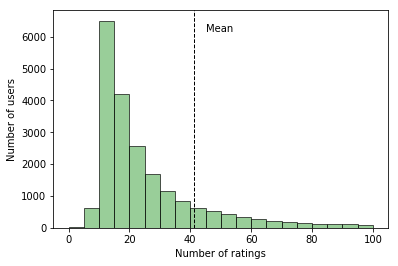

Number of users with no ratings:    2
Minimum ratings per user (>0):      1
Maximum ratings per user:           5337
Mean number of ratings per user:    41
Median number of ratings per user:  19


In [23]:
max_user_reviews = 100
per_user = X.astype(bool).sum(1).A1
mean_reviews_per_user = np.mean(per_user)
median_reviews_per_user = np.median(per_user)

x = sorted([n for n in per_user if n <= max_user_reviews]) 
plt.hist(x, bins=int(max_user_reviews/5), color='#63b463', edgecolor='k', alpha=0.65)
plt.axvline(mean_reviews_per_user, color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
_, max_ = plt.ylim()
plt.text(mean_reviews_per_user + mean_reviews_per_user/10, max_ - max_/10, 'Mean')
plt.show()

stats = {
    "Number of users with no ratings:": len(per_user[per_user==0]),
    "Minimum ratings per user (>0):": min(per_user[per_user>0]),
    "Maximum ratings per user:": max(per_user),
    "Mean number of ratings per user:": int(round(mean_reviews_per_user)),
    "Median number of ratings per user:": int(round(median_reviews_per_user)),
}

for k, v in stats.items():
    print(f'{k:<35} {v}')

There are 2 users with no ratings (there were 2 "gaps" in the index sequence in the original data) - as it is not clear why we have these gaps, they are basically treated as cold-start users and are not excluded from the analysis. The distribution of number of ratings per user is right-skewed, which was to be expected. Half of the users rated less than 20 items as indicated by the median, but the mean is right shifted due to the significant outliers.

Next, we look at the items-ratings area. Most of the iteams have very small amount of ratings and thus the plot has been restricted to 20 ratings. Due to the nature of the input data, we only have items that were rated at least once:

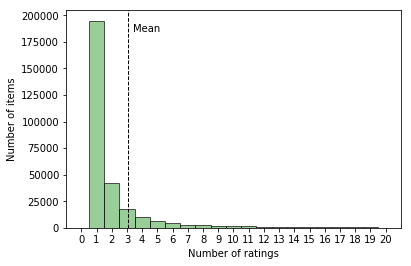

Minimum ratings per item:      1
Maximum ratings per item:      1742
Mean ratings per item:         3
Median ratings per item:       1


In [22]:
max_item_reviews = 21
per_item = X.astype(bool).sum(0).A1
mean_reviews_per_item = np.mean(per_item)
median_reviews_per_item = np.median(per_item)

x = sorted([n for n in per_item if n <= max_item_reviews])
plt.hist(x, bins=np.arange(21)-0.5, color='#63b463', edgecolor='k', alpha=0.65)
plt.xticks(range(21))
plt.xlim([-1, 21])
plt.axvline(mean_reviews_per_item, color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Number of ratings')
plt.ylabel('Number of items')
_, max_ = plt.ylim()
plt.text(mean_reviews_per_item + mean_reviews_per_item/10, max_ - max_/10, 'Mean')
plt.show()

stats = {
    "Minimum ratings per item:": min(per_item),
    "Maximum ratings per item:": max(per_item),
    "Mean ratings per item:": int(round(mean_reviews_per_item)),
    "Median ratings per item:": int(round(median_reviews_per_item)),
}

for k, v in stats.items():
    print(f'{k:<30} {v}')

Again the distribution is right-skewed and majority of the items have only 1 review (almost 200k items out of roughly 300k items set), with mean slightly shifted to the right by significant outliers. As expected, there are some very popular items rated by a significant number of users.

Lastly, we take a look at the trust data. The plot was restricted to 100 trust links per user, as majority of the users have only a few trust links. The provided dataset seems to contain only a fraction of trust links (trust links for about first 8k users, if ordered by user id):

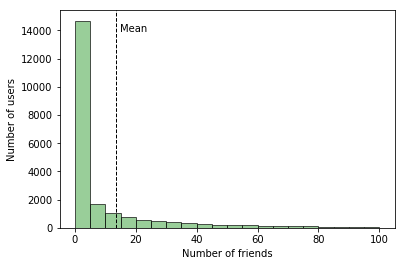

Number of users with no friends:              13652
Minimum friends per user (>0):                1
Maximum friends per user:                     1303
Mean friends per user:                        14
Median friends per user:                      0
Mean friends per user (trust network only):   35
Median friends per user (trust network only): 17


In [31]:
max_user_trust = 100
trust_stats = T.sum(1)
trust_per_user = trust_stats.A1
trust_per_user_nnz = trust_stats[np.nonzero(trust_stats)].A1
mean_trusted_per_user = np.mean(trust_per_user)
median_trusted_per_user = np.median(trust_per_user)
mean_trusted_per_user_nnz = np.mean(trust_per_user_nnz)
median_trusted_per_user_nnz = np.median(trust_per_user_nnz)

x = sorted([n for n in trust_per_user if n <= max_user_trust]) 
plt.hist(x, bins=int(max_user_trust/5), color='#63b463', edgecolor='k', alpha=0.65)
plt.axvline(mean_trusted_per_user, color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Number of friends')
plt.ylabel('Number of users')
_, max_ = plt.ylim()
plt.text(mean_trusted_per_user + mean_trusted_per_user/10, max_ - max_/10, 'Mean')
plt.show()

stats = {
    "Number of users with no friends:": len(trust_per_user[trust_per_user==0]),
    "Minimum friends per user (>0):": min(trust_per_user[trust_per_user>0]),
    "Maximum friends per user:": max(trust_per_user),
    "Mean friends per user:": int(round(mean_trusted_per_user)),
    "Median friends per user:": int(round(median_trusted_per_user)),
    "Mean friends per user (trust network only):": int(round(mean_trusted_per_user_nnz)),
    "Median friends per user (trust network only):": int(round(median_trusted_per_user_nnz)),
}

for k, v in stats.items():
    print(f'{k:<45} {v}')

As suggested earlier, the majority of the users does not appear in the trust network (as users who expressed trust in other users), which is reflected by both the number of users with no friends and the median. **The trust network is directed** and thus the notion of friend in this case study is also a directed value, meaning a friend of user x is a user that user x expressed trust to (not necessarily vice versa).

Additional stats are provided for trust network only, to have a better understanding of the mean and the median in the dataset, when restricted to this subset of users only.

## Prediction algorithm

I've decided to use enhanced Resnick's prediction formula to implement user-based collaborative filtering as a base of the algorithm. While this can require a lot of memory in many cases, the rating data is often very sparse and can be stored efficiently in sparse matrices. Additionally, the number of users in the provided dataset is significantly smaller than the number of items, which makes user-user similarity calculations much more feasible. This prediction function can be later on encapsulated in a recommendation system/function, where e.g. user would be recommended top-N items that he has not rated and these items would be rated by the prediciton function and returned in rating-descending order to the user an example of such implementation will be provided at the end of the study.

To incorporate trust in the algorithm, I've considered a few options before I settled on the final one presented in the case study (a trust network itself will be explained in details later in the study):
1. A **Trust-first algorithm** (*UTFA*), that used trust network only to make predictions and switched back to user similarity if no neighbours have been found in the trust network
2. A **Trust-add algorithm** (*UTAA*), which added weights from the trust network to the computed user similarity
3. A **Trust-boost algorithm** (*UTBA*) which improved on the UTAA by boosting (multiplying) user similarity weights by trust network weights and setting trust weights for non-existent similarity weights. **This algorithm has been chosen**

Experiments have been conducted on the algorithms with the same dataset, paritioning and sampling and various trust network weights. *UTFA* turned out to be the worst of the three with no improvements over a standard user similarity predictions. This could indicate, that in this case the trust network alone is not the best predictor and trust expressed by users does not necessarily fully align with the users' tastes. In many cases users with rich trust network have 0 user similarity.

*UTAA* had some very small improvements in certain areas (cold users in trust network), but it seems adding network weights to the user similarity weights was a bit too much and balancing these values turned out to not be successful.

*UTBA* turned out to be most consistent and will be described further down in the evaluation section. The final prediction formula is thus:

$r_{u,i} = \bar{r_{u}} + \frac{\sum\limits_{v\in{N}} w(u,v)\cdot(r_{v,i} - \bar{r_{v}})}{\sum\limits_{v\in{N}} \mid w(u,v)\mid}$

where $r_{u,i}$ is the predicted rating for user $u$ and item $i$, $\bar{r_{u}}$ is the average rating for user $u$, $N$ is the neighbourhood of user $u$ consisting of users, that also rated the item $i$, $w(u,v)$ is the similarity weight between users $u$ and $v$ (the larger the more similar the users are), $r_{v,i}$ is the rating that neighbour $v$ gave to item $i$ and $\bar{r_{v}}$ is the average rating for neighbour $v$.

### Utility functions

To measure user-similary, I used cosine similarity measure, defined for user vectors $u$ and $v$ as

$\frac {\pmb u \cdot \pmb v}{||\pmb u|| \cdot ||\pmb v||}$

This function computes similarity for all users present in the matrix A and uses a normalization to easier vectorization and computation efficiency. Pearson correlation was also tried, but resulted in significantly worse predictions during evaluation.

Input:  
`A` - a user-item ratings matrix, where users are rows, items are columns and values are ratings

Returns:  
*user-user sparse similarity matrix*

In [33]:
def get_cosine_similarity(A):
    col_normed_mat = pp.normalize(A.tocsc(), axis=1)
    
    return col_normed_mat * col_normed_mat.T

Next, we define a function that computes rating averages for all users in matrix A

Input:  
`A` - a user-item ratings matrix, where users are rows, items are columns and values are ratings

Returns:  
*1-D numpy array* with averages

In [8]:
def get_average_ratings(A):
    B = A.tocsr()
    sums = B.sum(axis=1).A1
    counts = np.diff(B.indptr)
    counts[counts==0] = 1
    
    return sums / counts

Next is the function to create trust-enhanced similarity matrix.
The `propagate` inner function creates an intermediary row for `propagated_network` matrix (which is then cached, as this matrix is independend of rating matrix used in the evaluation and can be re-used without re-computation). `similarity` inner function is used to compute the actual similarity matrix using the input user-similarity `sim` and trust network `trust` which is either the original trust network additionally weighted or the propagated network. Lastly, `compute` is the actual interface, where we specify what kind of `boost` we want for the input user-similarity matrix. At level 1 we get an enhancement with direct trust network (T1), with level 2 we get an enhancement with direct and indirect trust network (T2), otherwise we get the input user similarity.

Both T1 and T2 enhancements can introduce new weights in the user similarity matrix (as this in essence a union of two matrices with some extra value transformations) and thus can widen the neighbourhood of the user in comparison to the standard user-user similarity.

Input:  
`T` - a user-user trust matrix, where users are rows and columns and values are binary trust links  
`friend_weight` - weights for direct trust links ("friends")  
`friend_of_friend_weight` - weights for 2nd level trust links ("friends of a friend")

Returns:  
*A function* that computes enhanced similarity matrix, depending on the propagation level passed as an argument

In [9]:
def get_trust_network(T, friend_weight=0.3, friend_of_friend_weight=0.1):
    propagated_network = None
    def propagate(friends_ids):
        # sum all friends of friends in one row
        row = csr_matrix(np.ones(len(friends_ids))) * T[friends_ids]
        # set friends of friends weights
        row.data = np.repeat(friend_of_friend_weight, len(row.data))
        # reset direct friends weights
        data = np.repeat(friend_weight, len(friends_ids))
        coords = (np.zeros(len(friends_ids), dtype=int), friends_ids)
        row = row + csr_matrix((data, coords), shape=T[0].shape)
        row[0,[friends_ids]] = friend_weight
        return csr_matrix(row)
    
    def similarity(sim, trust):
        # binary similarity matrix
        bin_sim = csr_matrix((np.ones(len(sim.data)), sim.indices, sim.indptr), dtype=int, shape=sim.shape)
        # trust/sim intersection matrix
        trust_sim = bin_sim + bin_sim.multiply(trust)
        # trust leftover matrix
        trust_rest = trust - trust.multiply(bin_sim)
        
        return sim.multiply(trust_sim) + trust_rest
    
    def compute(sim, level):
        nonlocal propagated_network
        if level == 1:
            return similarity(sim, T*friend_weight)
        if level == 2:
            if propagated_network is None:
                propagated_network = vstack(list(map(propagate, T.tolil().rows)))
            return similarity(sim, propagated_network)
        else:
            return sim                   
        
    return compute    

Next we have a function that computes `k` neighbours for a user `user_id`, given similarity matrix `S` and item ratings vector `ratings`. 

Input:  
`S` - any user similarity matrix, where users are rows and columns and values are similairty weights  
`k` - number of nearest neighbours to find (can be *None* for all neighbours)  
`ratings` - a vector of ratings of an item we are interested in  
`user_id` - id (index) of a user we search neighbours for

Returns:  
*A tuple of two lists* - first list contains ordered weights, second one contains corresponding neighbours' ids

In [10]:
def get_neighbours(S, k, ratings, user_id):
    # first extract only the neighbours that actually rated the item, so we have a smaller vector to work on
    all_neighbours = S[user_id]
    indptr = [0, len(ratings.indices)]
    data = np.ones(len(ratings.indices))
    bin_ratings = csr_matrix((data, ratings.indices, indptr), shape=all_neighbours.shape)
    rating_neighbours = all_neighbours.multiply(bin_ratings)    
    
    # return early, if there are no neighbours that rated the given item
    if rating_neighbours.getnnz() == 0:
        return ([], [])
    
    # zip weights and user ids
    pairs = zip(rating_neighbours.data, rating_neighbours.indices)
    # sort the data so that larger weights (and their associated user ids) are first
    if k is not None:
        ordered = sorted(pairs, key=itemgetter(0), reverse=True)[:k]
    else:
        ordered = sorted(pairs, key=itemgetter(0), reverse=True) 

    return map(list, zip(*ordered))

Finally, we have the function to predict rating for user `user_id` and `item_id` based on the passed parameters. This function uses the Resnick formula introduced before. This is not a user-facing function and would be wrapped by a simpler interface.

It returns `-1` if no neighbour could be found, so it's easier to filter out unrated items in later stages. It also does not round the predictions to integers, as the floats are more useful for top-N recommendations that a wrapper could use. The rounding happens during the evaluation though.

Input:  
`U` - rating matrix, preferrably sparse csc_matrix  
`S` - any user similarity matrix, where users are rows and columns and values are similairty weights  
`A` - 1d vector with rating averages for users  
`k` - number of nearest neighbours to find (can be *None* for all neighbours)   
`user_id` - id (index) of a user we want to predict rating for  
`item_id` - id (index) of an item we want to predict rating for 

Returns:  
*rating prediction* - a value between 1 and 5 inclusive or -1 if no prediction could have been made

In [11]:
def predict(U, S, A, k, user_id, item_id):
    
    # get neighbours of user_id that rated item_id, sorted by similarity
    ratings = U[:,item_id]
    weights, neighbours = get_neighbours(S, k, ratings, user_id)
      
    # return average rating in 1-5 scale if there are no neighbours left or their weights are 0
    if len(neighbours) == 0 or sum(weights) == 0:
        return -1

    # compute users' average ratings and weights
    user_avg = A[user_id]
    neighbours_avg = A[neighbours]

    # compute weighted ratings
    ratings = sum(weights * (ratings[neighbours].T - neighbours_avg).A1)/sum(np.abs(weights))
    rating = user_avg + ratings
      
    if rating < 1:
        return 1
    elif rating > 5:
        return 5
    else:
        return rating

To easily evaluate the prediction algorithm, an evaluation function is introduced, taking a number of parameters to configure the evaluation scenarios. While it is common to use `leave-one-out` cross validation (*LOOCV*) for collaborative filtering algorithms (often appears in literature), it is also extremely time and resource consuming method, especially for memory-based systems, where matrix pre-computation would be much more tricky, as we would need to update them for n models. For that reason a classic `holdout` was chosen for this study.

As mentioned before, the evaluation function rounds the predictions before computing the differences, as we want to compare the same data types for ratings. The sample selection is random, but a seed has been put in place to get reproducible results. The tests were conducted without seeds as well.

Input:  
`R` - ratings (transactions) array read from the input file  
`sums` - 1d vector with number of ratings per user  
`tsums` - 1d vector with number of outgoing trust per user  
`ftrust` - a trust incorporating function  
`knn` - number of nearest neighbours passed to prediction function (can be None for "all")  
`train_index` - indices of train data in the R array  
`test_index` - indices of test data in the R array  
`tests_per_fold` - number of samples to check from the test data  
`trust_level` - how much trust to incorporate in the similairty matrix (0,1,2)  
`filters` - extra filters for the test data  

Returns:  
*(MAE, RMSE, missed ratings, total ratings, run time)* - a tuple with indicated values

In [12]:
def evaluate(R, sums, tsums, ftrust, knn, train_index, test_index, tests_per_fold, trust_level, filters):
    # create a training matrix with the same shape as full ratings matrix
    train_set = R[train_index]
    U = csc_matrix((train_set[:,2],(train_set[:,0],train_set[:,1])), shape=(num_users, num_items))
    # create user similairty and averages matrices baased on the passed parameters
    S = ftrust(get_cosine_similarity(U), trust_level)
    A = get_average_ratings(U)
    
    # get predictions for the test set
    s = time.perf_counter()
    # create test set
    y = R[test_index[0]:test_index[-1]+1]
    # apply filters to the test set
    if filters["max_ratings"] is not None:
        y = y[sums[y[:,0]] <= filters["max_ratings"]]
    if filters["min_ratings"] is not None:
        y = y[sums[y[:,0]] >= filters["min_ratings"]]
    if filters["trust_only"] is True:
        y = y[tsums[y[:,0]] > 0]
    # random sample from the test set, if required
    if tests_per_fold < len(y):
        np.random.seed(12345)
        idx = np.random.permutation(np.arange(len(y)))[:tests_per_fold]
        y = y[idx]
    if len(y) == 0:
        return (0, 0, 0, 0, 0)
    
    # run prediction for the entired (filtered) test set
    predictions = np.fromiter((predict(U, S, A, knn, u, i) for u,i,_ in y), y.dtype, count=len(y))
    mask = predictions > -1
    # compute difference between actual and predicted ratings
    diff = y[:,2][mask] - np.round(predictions[mask]).astype(int)
    t=time.perf_counter()-s
    
    # return MAE, RMSE
    return (sum(np.abs(diff))/len(diff), np.sqrt(diff.dot(diff)/len(diff)), len(mask[mask==False]), len(y), t)

In [13]:
#S = get_pearson_similarity(X.tocsc())
#A = get_average_ratings(X)
#predict(X.tocsc(), S, A, 2, 0, 3)
#%timeit X.sum(axis=1).A1 / np.diff(X.indptr)

In [14]:
splits = 10
neighbours = [5,10,20,30,40,50, None]
trust_levels = [0,1,2]
rating_threshold = {
    "all": {"trust_only": False, "min_ratings": None, "max_ratings": None},
    "all_trust": {"trust_only": True, "min_ratings": None, "max_ratings": None},
    "cold": {"trust_only": False, "min_ratings": None, "max_ratings": 15},
    "cold_trust": {"trust_only": True, "min_ratings": None, "max_ratings": 15},
    "active": {"trust_only": False, "min_ratings": 50, "max_ratings": None},
    "active_trust": {"trust_only": True, "min_ratings": 50, "max_ratings": None}
}

ftrust = get_trust_network(T, 0.2, 0.05)
tests_per_fold = 2000

sums = X.getnnz(axis=1)
tsums = T.getnnz(axis=1)
kf = KFold(n_splits=splits)

runs = splits * len(neighbours) * len(trust_levels) * len(rating_threshold)
print("Evaluation [{} runs]: ".format(runs), end='')
i = 1
results = []
s = time.perf_counter()

for threshold, max_ratings in rating_threshold.items():
    for trust_level in trust_levels:
        for k in neighbours:
            err_mae, err_rmse, t, p_missed, p_total = [], [], [], 0, 0
            for train_index, test_index in kf.split(R):
                mae, rmse, missed, total, t = evaluate(R, sums, tsums, ftrust, k, train_index, test_index, 
                                                       tests_per_fold, trust_level, max_ratings)
                if total > 0:
                    err_rmse.append(rmse)
                    err_mae.append(mae)
                    p_total += total
                    p_missed += missed
                if i %(runs/10) == 0:
                    print("{}%".format(int(i/runs*100)), end = ' ')
                i += 1
            if p_total > 0:
                results.append({"rmse": np.mean(err_rmse), "mae": np.mean(err_mae), 
                                "k": k, "avgtime": np.mean(t), "trust_level": trust_level,
                                "missed": p_missed, "total": p_total, "threshold": threshold})

import datetime
print("Done [{}]".format(datetime.timedelta(seconds=int(time.perf_counter()-s))))

Evaluation [1260 runs]: 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% Done [1:48:03]


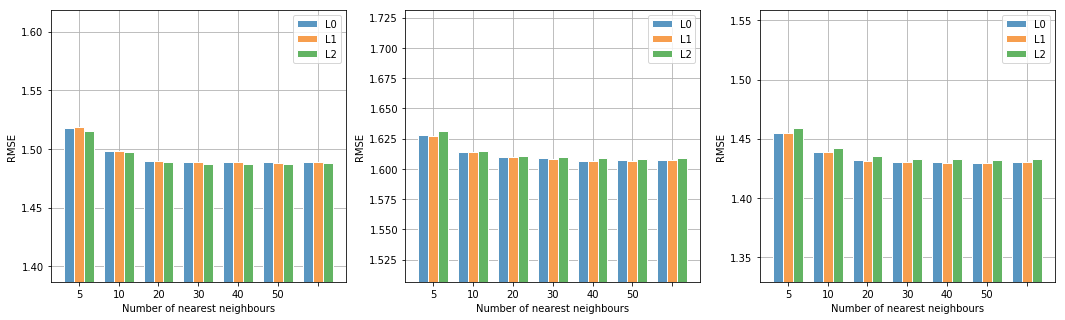

In [17]:
sorted_results = sorted(results, key=lambda x: x["k"] if x["k"] is not None else 9999)
def plot_bars(threshold, metric):
    L0 = [x[metric] for x in sorted_results if x["trust_level"] == 0 and x["threshold"] == threshold]
    L1 = [x[metric] for x in sorted_results if x["trust_level"] == 1 and x["threshold"] == threshold]
    L2 = [x[metric] for x in sorted_results if x["trust_level"] == 2 and x["threshold"] == threshold]
    bw = 0.25 

    r1 = np.arange(len(L0))
    r2 = [x + bw for x in r1]
    r3 = [x + bw for x in r2]
    
    plt.bar(r1, L0, color='#5996c1', width=bw, edgecolor='white', label='L0', zorder=3)
    plt.bar(r2, L1, color='#f79e4e', width=bw, edgecolor='white', label='L1', zorder=3)
    plt.bar(r3, L2, color='#63b463', width=bw, edgecolor='white', label='L2', zorder=3)

    plt.xlabel('Number of nearest neighbours')
    plt.ylabel('RMSE')
    plt.xticks([r + bw for r in range(len(L0))], neighbours)
    low = min([x[metric] for x in results if x["threshold"] == threshold])
    high = max([x[metric] for x in results if x["threshold"] == threshold])
    plt.ylim([low-0.1, high+0.1])
    
    plt.grid(zorder=0)
    plt.legend()

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plot_bars("all", "rmse")
plt.subplot(1,3,2)
plot_bars("cold", "rmse")
plt.subplot(1,3,3)
plot_bars("active", "rmse")
#63b463
#d96060
#ac8cc8    
plt.show()

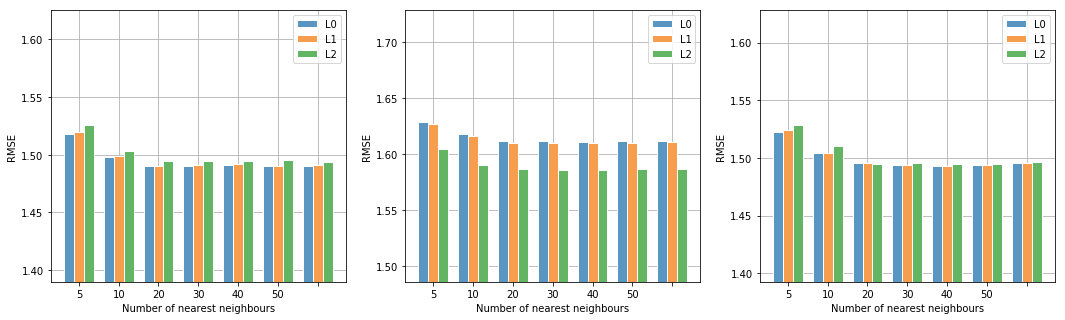

In [18]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plot_bars("all_trust", "rmse")
plt.subplot(1,3,2)
plot_bars("cold_trust", "rmse")
plt.subplot(1,3,3)
plot_bars("active_trust", "rmse")
#63b463
#d96060
#ac8cc8    
plt.show()

In [5]:
len(T.getnnz(axis=1))

22166